# Notebook for running the snmachine pipeline on Supernova Photometric Classification Challenge simulated data

This notebook illustrates the use of the `snmachine` supernova classification package by classifying a subset simulated data from the supernova photometric classification challenge (SPCC). 

See Lochner et al. (2016): http://arxiv.org/abs/1603.00882

NOTE: The results here differ slightly from the paper because we're using a much smaller dataset (in the interest of disk space and speed). Additionally, here the feature extraction methods use least squares (which is must faster) whereas in the paper we used nested sampling for more accurate fits.

<img src="pipeline.png" width=600>

This image illustrates the how the pipeline works. As the user, you can choose what feature extraction method you want to use. Here we have three (four, technically, since there are two parametric models) but it's straighforward to write a new feature extraction method. Once features have been extracted, they can be run through one of several machine learning algorithms and again, it's easy to write your own algorithm into the pipeline. There's a convenience function in `snclassifier` to run a feature set through multiple algorithms and plot the result. The rest of this notebook goes through applying each of the feature extraction methods to a set of simulations and running all feature sets through different classification algorithms.

In [1]:
!pip install ../../snmachine/

Processing /home/calves/plasticc/snmachine
  Created wheel for snmachine: filename=snmachine-1.6.1.dev164+ga7645f1.d20210630-py3-none-any.whl size=67026723 sha256=b23dfa186e1ea1b2a23a4ec0d186832926ffe56d9fcc978b7afb8975a86aff97
  Stored in directory: /tmp/pip-ephem-wheel-cache-yal3k7j1/wheels/13/7b/ca/00f02bcadf757a875da9908d15077f22cbe44117f06f581e95
Successfully built snmachine
  Attempting uninstall: snmachine
    Found existing installation: snmachine 1.6.1.dev164+ga7645f1.d20210630
    Uninstalling snmachine-1.6.1.dev164+ga7645f1.d20210630:
      Successfully uninstalled snmachine-1.6.1.dev164+ga7645f1.d20210630


In [2]:
import os

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [50]:
from snmachine import example_data, sndata, snfeatures, tsne_plot
from utils.plasticc_pipeline import create_folder_structure, get_directories

In [5]:
%config Completer.use_jedi = False  # enable autocomplete

#### Aestetic settings

In [6]:
%matplotlib nbagg

sns.set(font_scale=1.3, style="ticks")

In [ ]:
from __future__ import division
from snmachine import sndata, snfeatures, snclassifier, tsne_plot, example_data
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack
from astropy.io import fits
import sklearn.metrics 
import sncosmo

In [12]:
%%capture --no-stdout 
#I use this to supress unnecessary warnings for clarity
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
%matplotlib nbagg

## Set up output structure

We make lots of output files so it makes sense to put them in one place. This is the recommended output file structure.

We start by **naming** our analysis.

In [7]:
dataset_name = 'spcc'
analysis_name = os.path.join(f'output_{dataset_name}_no_z')

Then, we **write** in `folder_path` the path where to save the folder.

Note that `MultiNest` uses a hardcoded character limit for the output file names (we believe it is 100 characters). Thus, avoid making this file path to lengthy if using nested sampling otherwise the multinest output file names will be truncated.

In [8]:
folder_path = '.'

Create the folder structure.

In [9]:
create_folder_structure(folder_path, analysis_name)


                Folders already exist with this analysis name.

                Are you sure you would like to proceed, this will overwrite the
                output_spcc_no_z folder [Y/n]
                
Y
Overwriting existing folder..


See the folder structure. We save:
* the extracted features in `directories['features_directory']`
* the classification probabilities and ROC curves in `directories['classifications_directory']`
* the any intermediate files (such as multinest chains or GP fits) in `directories['intermediate_files_directory']`

In [9]:
directories = get_directories(folder_path, analysis_name) 
directories

{'analysis_directory': './output_spcc_no_z',
 'features_directory': './output_spcc_no_z/wavelet_features',
 'classifications_directory': './output_spcc_no_z/classifications',
 'intermediate_files_directory': './output_spcc_no_z/intermediate_files',
 'plots_directory': './output_spcc_no_z/plots'}

In [10]:
path_saved_features = directories['features_directory']
path_saved_interm = directories['intermediate_files_directory']
path_saved_classifier = directories['classifications_directory']

## Initialise dataset object

Load a subset of the SPCC DES simulated data (http://arxiv.org/abs/1008.1024). For that, we **write** the path where the data is. Alternatively, we can automatically untar the data.

In [11]:
data_path = os.path.join(example_data, 'SPCC_SUBSET', '')

In [12]:
if not os.path.exists(data_path):  # automatically untar the data
    subprocess.call(['tar', '-zxvf', 'SPCC_SUBSET.tar.gz'])

In [13]:
dataset = sndata.Dataset(data_path)

Reading data...
2000 objects read into memory.


For now we restrict ourselves to three supernova types: Ia (1), II (2) and Ibc (3).

In [14]:
types = dataset.get_types()
types['Type'][np.floor(types['Type']/10)==2] = 2
types['Type'][np.floor(types['Type']/10)==3] = 3

Now we can plot all the data and cycle through it (left and right arrows on your keyboard).

<IPython.core.display.Javascript object>


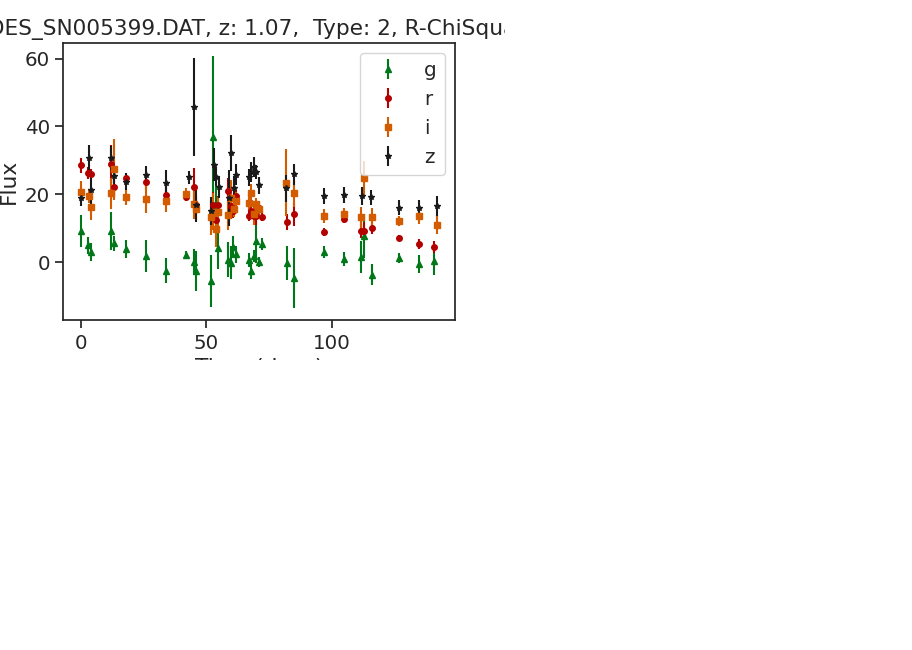

In [16]:
dataset.plot_all()

Each light curve is represented in the Dataset object as an astropy table, compatible with `sncosmo`:

In [17]:
dataset.data[dataset.object_names[0]]

mjd,filter,flux,flux_error,zp,zpsys
float64,str4,float64,float64,float64,str2
0.0,desg,-0.7663,10.48,27.5,ab
0.01600000000325963,desr,3.049,7.841,27.5,ab
0.03200000000651926,desi,0.4541,9.312,27.5,ab
0.9770000000062282,desz,4.622,5.329,27.5,ab
1.985000000000582,desg,0.8938,3.205,27.5,ab
2.0,desr,3.493,2.427,27.5,ab
2.0160000000032596,desi,-2.318,4.311,27.5,ab
9.957000000002154,desz,39.55,27.34,27.5,ab
10.105999999999767,desg,-26.03,25.58,27.5,ab


## Extract features for the data

The next step is to extract useful features from the data. This can often take a long time, depending on the feature extraction method, so it's a good idea to save these to file.

In [15]:
read_from_file = False  # use this flag to quickly rerun from saved features
run_name = os.path.join(path_saved_features, f'{dataset}_all')

### 1. SALT2 Template features

In [16]:
import os
import pickle
import subprocess
import sys
import time
import traceback

import numpy as np
import pandas as pd
import pywt
import sncosmo

from astropy.table import Table, vstack, join
from functools import partial
from iminuit import Minuit
from multiprocessing import Pool
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from snmachine import gps, chisq

In [36]:
# This is a Features object, not yet the extracted features
#salt2_features_instance = snfeatures.TemplateFeatures(sampler='leastsq') 

salt2_features_instance = TemplateFeatures(sampler='leastsq') 

This performs the actual feature extraction. All feature extraction methods are parallelised with multiprocessing, just set `nprocesses`>1 for parallelisation.

In [37]:
if read_from_file:
    print('Reading from file...')
    salt2_features = Table.read(f'{run_name}_templates.dat', 
                                format='ascii')
    better_name = salt2_features['Object'].astype(str)
    salt2_features.replace_column('Object', better_name)
else:
    print('Feature extraction...')
    salt2_features = salt2_features_instance.extract_features(
        dataset, use_redshift=True, number_processes=1, 
        chain_directory=path_saved_interm)
    salt2_features.write(f'{run_name}_templates.dat', format='ascii')

Feature extraction...
Fitting templates using leastsq ...
MODEL-NAME: Ia
0 objects fitted
100 objects fitted
200 objects fitted
300 objects fitted
400 objects fitted
500 objects fitted
600 objects fitted
700 objects fitted
800 objects fitted
900 objects fitted
1000 objects fitted
Obj. DES_SN486601.DAT failed.
1100 objects fitted
Obj. DES_SN528665.DAT failed.
1200 objects fitted
1300 objects fitted
1400 objects fitted
Obj. DES_SN661872.DAT failed.
1500 objects fitted
Obj. DES_SN705777.DAT failed.
1600 objects fitted
Obj. DES_SN728612.DAT failed.
1700 objects fitted
1800 objects fitted
Obj. DES_SN827906.DAT failed.
1900 objects fitted
2000 objects fitted
1156.4137818813324


In [27]:
aa = salt2_features.to_pandas()
aa.set_index('Object', inplace=True)

In [35]:
class TemplateFeatures(Features):
    """Calls sncosmo to fit a variety of templates to the data. The number of
    features will depend on the templates chosen (e.g. salt2, nugent2p etc.)
    """
    def __init__(self, model=['Ia'], sampler='leastsq', lsst_bands=False,
                 lsst_dir='../lsst_bands/'):
        """ To initialise, provide a list of models to fit for (defaults to
        salt2 Ia templates).

        Parameters
        ----------
        model : list-like, optional
            List of models. In theory you can fit Ia and non-Ia models and use
            all those as features. So far only tested with SALT2.
        sampler : str, optional
            A choice of 'mcmc', which uses the emcee sampler, or 'nested' or
            'leastsq' (default).
        lsst_bands : bool, optional
            Whether or not the LSST bands are required. Only need for LSST
            simulations to register bands with sncosmo.
        lsst_dir : str, optional
            Directory where LSST bands are stored.
        """
        Features.__init__(self)
        if lsst_bands:
            self.registerBands(lsst_dir, prefix='approxLSST_',
                               suffix='_total.dat')
        self.model_names = model
        self.templates = {'Ia': 'salt2-extended', 'salt2': 'salt2-extended',
                          'mlcs2k2': 'mlcs2k2', 'II': 'nugent-sn2n',
                          'IIn': 'nugent-sn2n', 'IIp': 'nugent-sn2p',
                          'IIl': 'nugent-sn2l', 'Ibc': 'nugent-sn1bc',
                          'Ib': 'nugent-sn1bc', 'Ic': 'nugent-sn1bc'}
        # Short names because of limitations in Multinest
        self.short_names = {'Ia': 'salt2', 'mlcs2k2': 'mlcs'}
        if sampler == 'nested':
            try:
                import pymultinest
            except ImportError:
                print('Nested sampling selected but pymultinest is not '
                      'installed. Defaulting to least squares.')
                sampler = 'leastsq'
        elif sampler == 'mcmc':
            try:
                import emcee
            except ImportError:
                print('MCMC sampling selected but emcee is not installed. '
                      'Defaulting to least squares.')
                sampler = 'leastsq'

        self.sampler = sampler
        self.bounds = {'salt2-extended': {'z': (0.01, 1.5), 't0': (-100, 100),
                                          'x0': (-1e-3, 1e-3), 'x1': (-3, 3),
                                          'c': (-0.5, 0.5)},
                       'mlcs2k2': {'z': (0.01, 1.5), 't0': (-100, 100),
                                   'amplitude': (0, 1e-17),
                                   'delta': (-1.0, 1.8), 'hostebv': (0, 1),
                                   'hostr_v': (-7.0, 7.0)},
                       'nugent-sn2n': {'z': (0.01, 1.5)},
                       'nugent-sn2p': {'z': (0.01, 1.5)},
                       'nugent-sn2l': {'z': (0.01, 1.5)},
                       'nugent-sn1bc': {'z': (0.01, 1.5)}}

    def extract_features(self, d, save_output=False, chain_directory='chains',
                         use_redshift=False, number_processes=1, restart=False,
                         seed=-1):
        """Extract template features for a dataset.

        Parameters
        ----------
        d : Dataset object
            Dataset
        save_output : bool
            Whether or not to save the intermediate output (if Bayesian
            inference is used instead of least squares)
        chain_directory : str
            Where to save the chains
        use_redshift : bool
            Whether or not to use provided redshift when fitting objects
        number_processes : int, optional
            Number of processors to use for parallelisation (shared memory
            only).
        restart : bool
            Whether or not to restart from multinest chains

        Returns
        -------
        astropy.table.Table
            Table of fitted model parameters.
        """
        subprocess.call(['mkdir', chain_directory])
        print('Fitting templates using', self.sampler, '...')
        all_output = []
        t1 = time.time()
        for mod_name in self.model_names:
            if mod_name == 'mlcs2k2':
                dust = sncosmo.CCM89Dust()
                self.model = sncosmo.Model(self.templates[mod_name],
                                           effects=[dust],
                                           effect_names=['host'],
                                           effect_frames=['rest'])
            else:
                self.model = sncosmo.Model(self.templates[mod_name])
                print(F'MODEL-NAME: {mod_name}')
            params = ['['+mod_name+']'+pname
                      for pname in self.model.param_names]
            labels = ['Object'] + params
            output = Table(names=labels,
                           dtype=['U32'] + ['f'] * (len(labels) - 1))
            k = 0
            if number_processes < 2:
                for obj in d.object_names:
                    if k % 100 == 0:
                        print(k, 'objects fitted')
                    lc = d.data[obj]

                    if self.sampler == 'mcmc':
                        if seed != -1:
                            np.random.seed(seed)
                        res, fitted_model = sncosmo.mcmc_lc(
                            lc, self.model, self.model.param_names,
                            bounds=self.bounds[self.templates[mod_name]],
                            nwalkers=20, nsamples=1500, nburn=300)
                        chain = res.samples
                        if save_output:
                            tab = Table(chain, names=self.model.param_names)
                            path_to_save = os.path.join(
                                chain_directory,
                                obj.split('.')[0]+'_emcee_'+mod_name)
                            tab.write(path_to_save, format='ascii')
                        best = res['parameters'].flatten('F').tolist()
                    elif self.sampler == 'nested':
                        best = _run_multinest_templates(
                            obj, d, self.templates[mod_name],
                            self.bounds[self.templates[mod_name]],
                            chain_directory=chain_directory, nlp=1000,
                            convert_to_binary=False, use_redshift=use_redshift,
                            short_name=self.short_names[mod_name],
                            restart=restart, seed=seed)
                        best = best.tolist()
                    elif self.sampler == 'leastsq':
                        if use_redshift:
                            self.model.set(z=lc.meta['z'])
                            prms = self.model.param_names
                            prms = prms[1:]
                            bnds = self.bounds[self.templates[mod_name]].copy()
                            bnds.pop('z', None)
                            try:
                                res, fitted_model = sncosmo.fit_lc(
                                    lc, self.model, vparam_names=prms,
                                    bounds=bnds, minsnr=0)
                            except RuntimeError:  # the event failed to fit
                                print(f'Obj. {obj} failed.')
                        else:
                            try:
                                res, fitted_model = sncosmo.fit_lc(
                                    lc, self.model, minsnr=0,
                                    vparam_names=self.model.param_names,
                                    bounds=self.bounds[
                                        self.templates[mod_name]])
                                print(res)
                            except RuntimeError:  # the event failed to fit
                                print(f'Obj. {obj} failed.')
                                res = {}
                        best = res['parameters'].flatten('F').tolist()
                    row = [obj]+best
                    output.add_row(row)
                    k += 1
                if len(all_output) == 0:
                    all_output = output
                else:
                    all_output = join(all_output, output)
            else:
                if self.sampler == 'leastsq':
                    p = Pool(number_processes, maxtasksperchild=1)
                    partial_func = partial(_run_leastsq_templates, d=d,
                                           model_name=self.templates[mod_name],
                                           use_redshift=use_redshift,
                                           bounds=self.bounds[
                                               self.templates[mod_name]])
                    out = p.map(partial_func, d.object_names)
                    output = out[0]
                    for i in range(1, len(out)):
                        output = vstack((output, out[i]))
                    if len(all_output) == 0:
                        all_output = output
                    else:
                        all_output = vstack((all_output, output))
                elif self.sampler == 'nested':
                    p = Pool(number_processes, maxtasksperchild=1)
                    partial_func = partial(_run_multinest_templates, d=d,
                                           model_name=self.templates[mod_name],
                                           bounds=self.bounds[
                                               self.templates[mod_name]],
                                           chain_directory=chain_directory,
                                           nlp=1000, convert_to_binary=True,
                                           use_redshift=use_redshift,
                                           short_name=self.short_names[
                                               mod_name],
                                           restart=restart, seed=seed)
                    out = p.map(partial_func, d.object_names)

                    for i in range(len(out)):
                        output.add_row([d.object_names[i]]+out[i].tolist())
                    if len(all_output) == 0:
                        all_output = output
                    else:
                        all_output = vstack((all_output, output))
        print(len(all_output), 'objects fitted')
        print(time.time()-t1)
        return all_output
  
    def fit_sn(self, lc, features):
        """Fits the chosen template model to a given light curve.

        Parameters
        ----------
        lc : astropy.table.Table
            Light curve
        features : astropy.table.Table
            Model parameters

        Returns
        -------
        astropy.table.Table
            Fitted light curve
        """
        obj = lc.meta['name']
        tab = features[features['Object'] == obj]
        params = np.array([tab[c] for c in tab.columns[1:]]).flatten()

        if len(params) == 0:
            print('No feature set found for', obj)
            return None

        model_name = self.templates[self.model_names[0]]
        if model_name == 'mlcs2k2':
            dust = sncosmo.CCM89Dust()
            model = sncosmo.Model(model_name, effects=[dust],
                                  effect_names=['host'],
                                  effect_frames=['rest'])
        else:
            model = sncosmo.Model(model_name)

        param_dict = {}
        for i in range(len(model.param_names)):
            param_dict[model.param_names[i]] = params[i]
        model.set(**param_dict)

        filts = np.unique(lc['filter'])
        labels = ['mjd', 'flux', 'filter']
        output = Table(names=labels, dtype=['f', 'f', 'U32'],
                       meta={'name': obj})
        for filt in filts:
            x = lc['mjd'][lc['filter'] == filt]
            xnew = np.linspace(0, x.max()-x.min(), 100)
            ynew = model.bandflux(filt, xnew, zp=27.5, zpsys='ab')
            newtable = Table([xnew+x.min(), ynew, [filt]*len(xnew)],
                             names=labels)
            output = vstack((output, newtable))
        return output

    def registerBands(self, dirname, prefix=None, suffix=None):
        """Register LSST bandpasses with sncosmo.
           Courtesy of Rahul Biswas"""
        bands = ['u', 'g', 'r', 'i', 'z', 'y']
        for band in bands:
            fname = os.path.join(dirname, prefix + band + suffix)
            data = np.loadtxt(fname)
            bp = sncosmo.Bandpass(wave=data[:, 0], trans=data[:, 1],
                                  name='lsst'+band)
            sncosmo.registry.register(bp, force=True)

    def goodness_of_fit(self, d):
        """Legacy code - to be deprecated. Use `compute_overall_chisq_over_pts`
        from `chisq.py`.

        Test (for any feature set) how well the reconstruction from the
        features fits each of the objects in the dataset.

        Parameters
        ----------
        d : Dataset
            Dataset object.

        Returns
        -------
        astropy.table.Table
            Table with the reduced Chi2 for each object
        """
        if len(d.models) == 0:
            print('Call Dataset.set_models first.')
            return None
        filts = np.unique(d.data[d.object_names[0]]['filter'])
        filts = np.array(filts).tolist()
        rcs = Table(names=['Object']+filts,
                    dtype=['U32']+['float64']*len(filts))  # Reduced chi2
        for obj in d.object_names:
            # Go through each filter
            chi2 = []
            lc = d.data[obj]
            mod = d.models[obj]
            for filt in filts:
                lc_filt = lc[lc['filter'] == filt]
                m = mod[mod['filter'] == filt]
                x = lc_filt['mjd']
                y = lc_filt['flux']
                e = lc_filt['flux_error']
                xmod = m['mjd']
                ymod = m['flux']
                # Interpolate
                fit = interp1d(xmod, ymod)
                yfit = fit(x)
                chi2.append(sum((yfit-y)**2/e**2)/(len(x)-1))
            rcs.add_row([obj]+chi2)
        return rcs

In [17]:
class Features:
    """Base class to define basic functionality for extracting features from
    supernova datasets. Users are not restricted to inheriting from this class,
    but any Features class must contain the functions `extract_features` and
    `fit_sn`.
    """
    def __init__(self):
        # At what point to we suggest a model has been a bad fit.
        self.p_limit = 0.05

    def extract_features(self):
        raise NotImplementedError('This method has not been implemented yet.')

    def fit_sn(self):
        raise NotImplementedError('This method has not been implemented yet.')

    @staticmethod
    def _exists_path(path_to_test):
        """Check if the inputed path exists.

        Parameters
        ----------
        path_to_test: str
            Path to test the existence.

        Raises
        ------
        ValueError
            If the provided path does not exist.
        """
        exists_path = os.path.exists(path_to_test)
        if not exists_path:
            raise ValueError('The path {} does not exist. Provide a valid path'
                             '.'.format(path_to_test))

In [32]:
if read_from_file:
    print('Reading from file...')
    salt2_features = Table.read(f'{run_name}_templates.dat', 
                                format='ascii')
    better_name = salt2_features['Object'].astype(str)
    salt2_features.replace_column('Object', better_name)
else:
    print('Feature extraction...')
    salt2_features = salt2_features_instance.extract_features(
        dataset, use_redshift=True, number_processes=4, 
        chain_directory=path_saved_interm)
    salt2_features.write(f'{run_name}_templates.dat', format='ascii')

Feature extraction...
Fitting templates using leastsq ...
MODEL-NAME: Ia


RuntimeError: result is NaN for [ 0.6421 -37.0659 5.13706e-06 nan -0.0445148 ]

In [42]:
lc = dataset.data['DES_SN000642.DAT']

In [43]:
salt2_features_instance.fit_sn(lc, salt2_features)

mjd,flux,filter
float64,float64,str32
0.0,0.03996984528762646,desg
1.5942222222222358,0.0757028672230526,desg
3.1884444444444715,0.1427829147677963,desg
4.7826666666667075,0.23302178324753803,desg
6.376888888888943,0.34107434684862525,desg
7.9711111111111785,0.46540272562406815,desg
9.565333333333415,0.6069090506386507,desg
11.15955555555565,0.7667909834666446,desg
12.753777777777886,0.9465798176765148,desg


Then, we take the fitted parameters and generate the model light curve for plotting purposes.

In [45]:
dataset.set_model(salt2_features_instance.fit_sn, salt2_features)

Fitting transient models...
Models fitted.


Now we can see how well the SALT2 model fits our light curves.

<IPython.core.display.Javascript object>


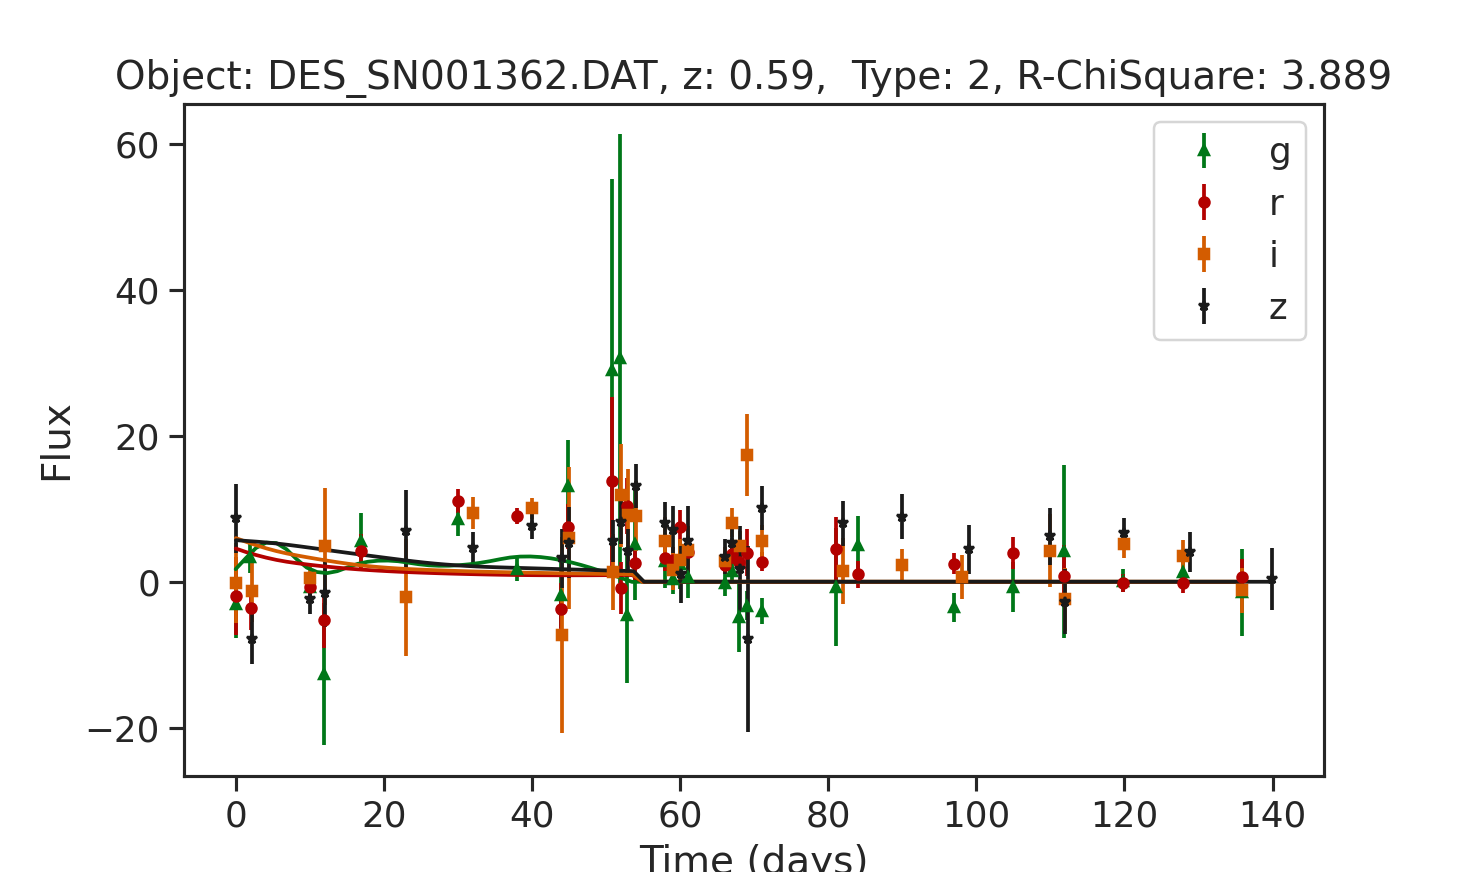

In [46]:
dataset.plot_all()

t-SNE plots: 
These are useful visualisation plots which embed high dimensional features into a lower dimensional space to indicate how well the features separate between classes (see https://lvdmaaten.github.io/tsne/).

<IPython.core.display.Javascript object>


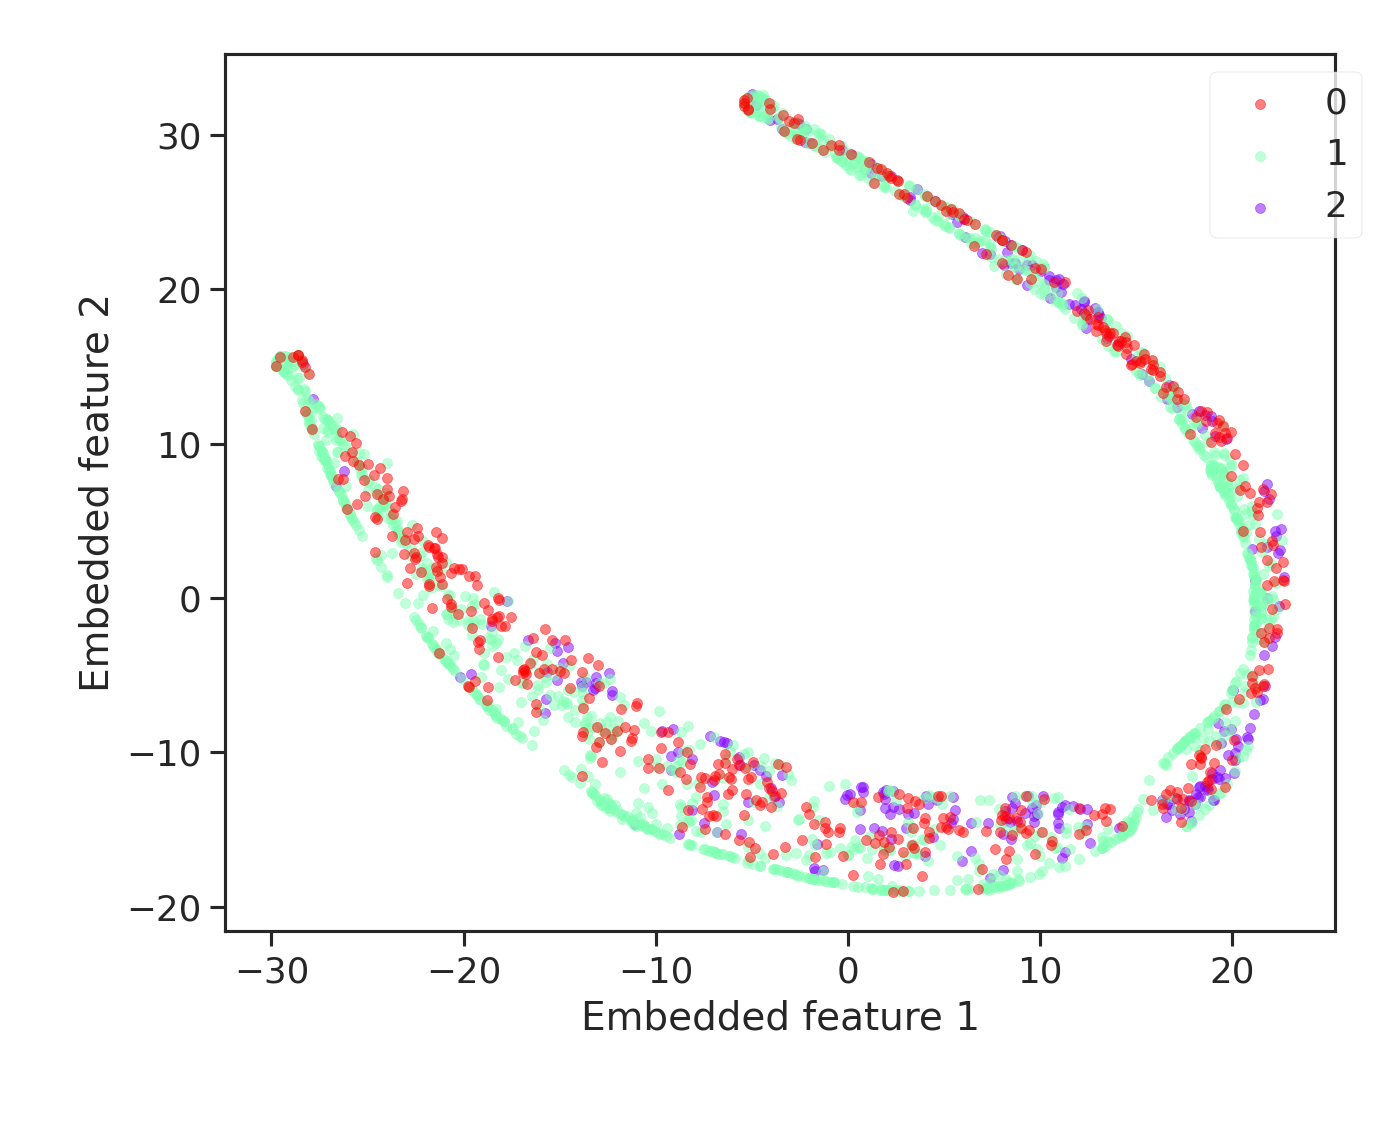

In [51]:
plt.figure()
tsne_plot.plot(salt2_features, join(salt2_features, types)['Type'])

### 2.1 Parametric fits - model 1 (Newling et al.)

In [48]:
model1_features_instance = snfeatures.ParametricFeatures(
    'newling', sampler='leastsq')

In [49]:
%%capture --no-stdout
if read_from_file:
    model1_features = Table.read(f'{run_name}_newling.dat', 
                               format='ascii')
    better_name = mod1_features['Object'].astype(str)
    read_from_file.replace_column('Object', better_name)
else:
    read_from_file = model1_features_instance.extract_features(
        dataset, number_processes=1, chain_directory=path_saved_interm)
    read_from_file.write(f'{run_name}_newling.dat', format='ascii')

0 objects fitted


RuntimeError: pedantic is not one of the parameters []

Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.

In [37]:
for c in mod1_features.colnames[1:]:
    model1_features[c][np.isnan(model1_features[c])] = 0

NameError: name 'mod1_features' is not defined

Finally, we take the features and generate the model light curve for plotting purposes.

In [ ]:
dataset.set_model(model1_features_instance.fit_sn, model1_features)

Now we can see how well the SALT2 model fits our light curves.

In [ ]:
dataset.plot_all()

We also make a t-SNE plot.

In [ ]:
plt.figure()
tsne_plot.plot(model1_features, join(model1_features, types)['Type'])

### 2.2 Parametric fits - model 2 (Karpenka et al.)

In [38]:
model2_features_instance = snfeatures.ParametricFeatures(
    'karpenka', sampler='leastsq')

In [39]:
%%capture --no-stdout
if read_from_file:
    model2_features = Table.read(f'{run_name}_karpenka.dat', format='ascii')
    better_name = model2_features['Object'].astype(str)
    model2_features.replace_column('Object', better_name)
else:
    model2_features = model2_features_instance.extract_features(
        dataset, number_processes=4, chain_directory=path_saved_interm)
    model2_features.write(f'{run_name}_karpenka.dat', format='ascii')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/calves/.conda/envs/snmachine/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-75a6e50b62b0>", line 7, in <module>
    dataset, number_processes=4, chain_directory=path_saved_interm)
  File "/home/calves/.conda/envs/snmachine/lib/python3.7/site-packages/snmachine/snfeatures.py", line 1083, in extract_features
    out = p.map(partial_func, d.object_names)
  File "/home/calves/.conda/envs/snmachine/lib/python3.7/multiprocessing/pool.py", line 268, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/home/calves/.conda/envs/snmachine/lib/python3.7/multiprocessing/pool.py", line 651, in get
    self.wait(timeout)
  File "/home/calves/.conda/envs/snmachine/lib/python3.7/multiprocessing/pool.py", line 648, in wait
    self._event.wait(timeout)
  File "/home/calves/.conda/envs/snmachine/lib/python3.

KeyboardInterrupt: 

Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.

In [40]:
for c in model2_features.colnames[1:]:
    model2_features[c][np.isnan(model2_features[c])] = 0

NameError: name 'model2_features' is not defined

Finally, we take the features and generate the model light curve for plotting purposes.

In [ ]:
dataset.set_model(model2_features_instance.fit_sn, model2_features)

Now we can see how well the SALT2 model fits our light curves.

In [ ]:
dataset.plot_all()

We also make a t-SNE plot.

In [ ]:
plt.figure()
tsne_plot.plot(model2_features, join(model2_features, types)['Type'])

### 3. Wavelet features

The wavelet feature extraction process is quite complicated, although it is fairly fast. Remember to save the PCA eigenvalues, vectors and mean for later reconstruction!

In [ ]:
wavelet_features_instance = snfeatures.WaveletFeatures()

In [ ]:
%%capture --no-stdout
if read_from_file:
    wavelet_features = Table.read(f'{run_name}_wavelets.dat', format='ascii')
    #Crucial for this format of id's
    better_name = wavelet_features['Object'].astype(str)
    wavelet_features.replace_column('Object', better_name)
    PCA_vals = np.loadtxt(f'{run_name}_wavelets_PCA_vals.dat')
    PCA_vec = np.loadtxt(f'{run_name}_wavelets_PCA_vec.dat')
    PCA_mean = np.loadtxt(f'{run_name}_wavelets_PCA_mean.dat')
else:
    wavelet_features = wavelet_features_instance.extract_features(
        dataset, number_processes=4, output_root=path_saved_interm,
        save_output='all')  # TODO -> this will likely fail
    wavelet_features.write(f'{run_name}_wavelets.dat', format='ascii')
    
    PCA_vals = wavelet_features_instance.PCA_eigenvals
    PCA_vec = wavelet_features_instance.PCA_eigenvectors
    PCA_mean = wavelet_features_instance.PCA_mean
    
    np.savetxt(f'{run_name}_wavelets_PCA_vals.dat', PCA_vals)
    np.savetxt(f'{run_name}_wavelets_PCA_vec.dat', PCA_vec)
    np.savetxt(f'{run_name}_wavelets_PCA_mean.dat', PCA_mean)

Finally, we take the features and generate the model light curve for plotting purposes.

In [ ]:
dataset.set_model(wavelet_features_instance.fit_sn,
                  wavelet_features, PCA_vec, PCA_mean, 0, 
                  dataset.get_max_length(), dataset.filter_set)

Now we can see how well the SALT2 model fits our light curves.

In [ ]:
dataset.plot_all()

We also make a t-SNE plot.

In [ ]:
plt.figure()
tsne_plot.plot(wavelet_features, join(wavelet_features, types)['Type'])

## Classify

Finally, we're ready to run the machine learning algorithm. There's a utility function in the `snclassifier` library to make it easy to run all the algorithms available, including converting features to `numpy` arrays and rescaling them and automatically generating ROC curves and metrics. Hyperparameters are automatically selected using a grid search combined with cross-validation. All functionality can also be individually run from `snclassifier`.

Classifiers can be run in parallel, change `number_processes` to the number of processors on your machine (we're only running 4 algorithms so it won't help to set this any higher than 4).

In [ ]:
number_processes = 4

In [ ]:
print('The available classifiers are:', snclassifier.choice_of_classifiers)

In [ ]:
which_column = 0  # SN Ia is the first column

### 1. SALT2 Template features

In [ ]:
plt.figure()
classifier_instances, cms = snclassifier.run_several_classifiers(
    classifier_list=['nb','knn','svm','boost_dt'], 
    features=salt2_features, labels=types,  scoring='accuracy', 
    train_set=.3, scale_features=True, which_column=which_column, 
    random_seed=42, output_root=path_saved_classifier,
    **{'plot_roc_curve': True, 'number_processes': number_processes})

### 2.1 Parametric fits - model 1 (Newling et al.)

In [ ]:
plt.figure()
classifier_instances, cms = snclassifier.run_several_classifiers(
    classifier_list=['nb','knn','svm','boost_dt'], 
    features=model1_features, labels=types,  scoring='accuracy', 
    train_set=.3, scale_features=True, which_column=which_column, 
    random_seed=42, output_root=path_saved_classifier,
    **{'plot_roc_curve': True, 'number_processes': number_processes})

### 2.2 Parametric fits - model 2 (Karpenka et al.)

In [ ]:
plt.figure()
classifier_instances, cms = snclassifier.run_several_classifiers(
    classifier_list=['nb','knn','svm','boost_dt'], 
    features=model2_features, labels=types,  scoring='accuracy', 
    train_set=.3, scale_features=True, which_column=which_column, 
    random_seed=42, output_root=path_saved_classifier,
    **{'plot_roc_curve': True, 'number_processes': number_processes})

### 3. Wavelet features

In [ ]:
plt.figure()
classifier_instances, cms = snclassifier.run_several_classifiers(
    classifier_list=['nb','knn','svm','boost_dt'], 
    features=wavelet_features, labels=types,  scoring='accuracy', 
    train_set=.3, scale_features=True, which_column=which_column, 
    random_seed=42, output_root=path_saved_classifier,
    **{'plot_roc_curve': True, 'number_processes': number_processes})

[Go back to top.](#index)